In [ ]:
!pip install matplotlib

In [ ]:
!pip install seaborn

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install spotipy

In [725]:
import pandas as pd
import numpy as np
import glob
import os
from os import listdir
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import tensorflow as tf
import sklearn 
from sklearn.utils import shuffle
from tensorflow import keras
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from tensorflow.keras.layers import Dense, LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import Model, Sequential, save_model, load_model
from tensorflow.config import list_logical_devices
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [726]:
# Spotipy user config

client_id="468661e92a884784968d2bec32d8dd09"
client_secret="9751a57846e442ea85fc1db2218fcf35"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

In [508]:
def get_decade(year):
    """
    Get quantity of songs released per decade 
    """
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    
    return decade

In [727]:
def wrangle():
    """
    wrangling function to load dataset, clean text & create additional features
    """
    # read in just the US spotify dataset
    df = pd.read_csv("C:\\Users\\trewq\\OneDrive\\Documents\\Lambda\\Unit 4\\buildweek\\files\\us.csv")
    
    # General House Keeping--clean the artist and artist_id text
    df['artists'] = df['artists'].str.strip('['']')
    df['artists'] = df['artists'].str.strip('""')
    df['artists'] = df['artists'].str.replace("'", "")

    df['id_artists'] = df['id_artists'].str.strip('['']')
    df['id_artists'] = df['id_artists'].str.strip('""')
    df['id_artists'] = df['id_artists'].str.replace("'", "")

    # create combined feature (song name - artist)
    df['combined'] = df['name'] + ' - ' + df['artists']
    
    # create decades feature for graphing
    df['year'] = pd.DatetimeIndex(df['release_date']).year
    df['decade'] = df['year'].apply(get_decade)
    
    # combine url and id for song to query results using Spotipy
    url = 'http://open.spotify.com/track/' + df['id']
    df['url'] = url

    return df

In [728]:
df = wrangle()

In [729]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,Uli,45tIt06XoI0Iio4LBEVpls,1922-02-22,0.645,0.4450,...,0.674,0.7440,0.151,0.127,104.851,3,Carve - Uli,1922,1920s,http://open.spotify.com/track/35iwgR4jXetI318W...
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,Fernando Pessoa,14jtPCOoNZwquk5wd9DxrY,1922-06-01,0.695,0.2630,...,0.797,0.0000,0.148,0.655,102.009,1,Capítulo 2.16 - Banquero Anarquista - Fernando...,1922,1920s,http://open.spotify.com/track/021ht4sdgPcrDgSk...
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.434,0.1770,...,0.994,0.0218,0.212,0.457,130.418,5,Vivo para Quererte - Remasterizado - Ignacio C...,1922,1920s,http://open.spotify.com/track/07A5yehtSnoedViJ...
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,Ignacio Corsini,5LiOoJbxVSAMkBS2fUm3X2,1922-03-21,0.321,0.0946,...,0.995,0.9180,0.104,0.397,169.980,3,El Prisionero - Remasterizado - Ignacio Corsini,1922,1920s,http://open.spotify.com/track/08FmqUhxtyLTn6pA...
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,Dick Haymes,3BiJGZsyX9sJchTqcSA7Su,1922,0.402,0.1580,...,0.989,0.1300,0.311,0.196,103.220,4,Lady of the Evening - Dick Haymes,1922,1920s,http://open.spotify.com/track/08y9GfoqCWfOGsKd...


In [730]:
# this will show rows that are 100% equal to other rows. 
df.duplicated().value_counts()

False    93135
dtype: int64

In [134]:
# it was considered to drop duplicated names however after further review there 
# are some songs named the same thing from different artists. Also there are a few cases where songs 
# from the same artist with the same name have almost identical features but are not 100% identical
# It is difficult to know if this is erroneous information or if they are merely different versions
# of the same song ex. acoustic version, live version, concert version etc. 

df.duplicated(subset=['name']).value_counts()

False    77927
True     15208
dtype: int64

In [515]:
df.shape

(93135, 23)

In [516]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93135 entries, 0 to 93134
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                93135 non-null  object 
 1   name              93135 non-null  object 
 2   popularity        93135 non-null  int64  
 3   duration_ms       93135 non-null  int64  
 4   explicit          93135 non-null  int64  
 5   artists           93135 non-null  object 
 6   id_artists        93135 non-null  object 
 7   release_date      93135 non-null  object 
 8   danceability      93135 non-null  float64
 9   energy            93135 non-null  float64
 10  key               93135 non-null  int64  
 11  loudness          93135 non-null  float64
 12  mode              93135 non-null  int64  
 13  speechiness       93135 non-null  float64
 14  acousticness      93135 non-null  float64
 15  instrumentalness  93135 non-null  float64
 16  liveness          93135 non-null  float6

In [518]:
df.nunique()

id                  93135
name                77927
popularity            101
duration_ms         38215
explicit                2
artists             21582
id_artists          21617
release_date         8442
danceability         1120
energy               2095
key                    12
loudness            22419
mode                    2
speechiness          1544
acousticness         4545
instrumentalness     5381
liveness             1714
valence              1642
tempo               59630
time_signature          5
combined            87509
year                  100
decade                 11
dtype: int64

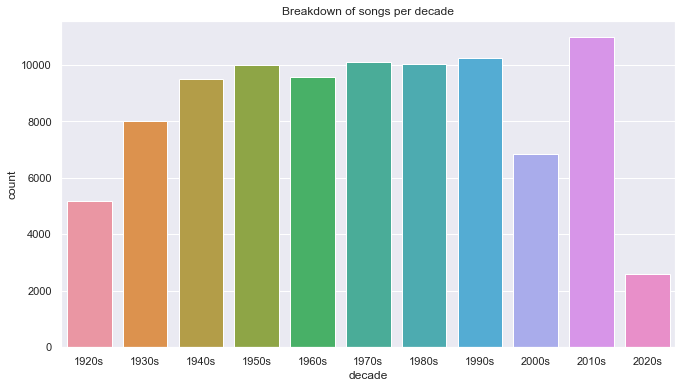

In [519]:
# Breakdown of songs per decade

plt.title('Breakdown of songs per decade')
sns.set(rc={'figure.figsize':(11 ,6)})
sns.countplot(df['decade'].sort_values())
plt.show()

In [145]:
#top artist by popularity of songs

df.groupby("artists")["popularity"].sum().sort_values(ascending=False).head(20)

artists
['The Beatles']                 17479
['Frank Sinatra']               12864
['The Rolling Stones']          11913
['Taylor Swift']                11480
['Fleetwood Mac']               10994
['Elvis Presley']               10928
['Led Zeppelin']                10596
['Bob Marley & The Wailers']     9684
['Pink Floyd']                   9141
['David Bowie']                  8039
['Queen']                        7800
['The Beach Boys']               7644
['Billie Holiday']               7565
['Johnny Cash']                  7454
['Bob Dylan']                    7375
['Dean Martin']                  6708
['Vicente Fernández']            6401
['Billy Joel']                   6388
['Metallica']                    5933
['AC/DC']                        5892
Name: popularity, dtype: int64

**------------------------------Predictions------------------------------------**


In [753]:
# segment numerical features and save in DataFrame
data = df.select_dtypes('number')
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,6,126903,0,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,0,98200,0,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,0,181640,0,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,0,176907,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,0,163080,0,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


In [754]:
def normalize_column(col):
    """
    function to normalize data in numerical features
    """
    max_d = data[col].max()
    min_d = data[col].min()
    data[col] = (data[col] - min_d)/(max_d - min_d)
    
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num = data.select_dtypes(include=num_types)
        
for col in num.columns:
    normalize_column(col)
    

In [755]:
# DataFrame with only numerical features
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,year
0,0.06,0.025400,0.0,0.652834,0.4450,0.000000,0.730749,1.0,0.464948,0.676707,0.7440,0.151151,0.127,0.430826,0.6,0.0
1,0.00,0.019414,0.0,0.703441,0.2630,0.000000,0.592968,1.0,0.986598,0.800201,0.0000,0.148148,0.655,0.419148,0.2,0.0
2,0.00,0.036816,0.0,0.439271,0.1770,0.090909,0.607940,1.0,0.052784,0.997992,0.0218,0.212212,0.457,0.535879,1.0,0.0
3,0.00,0.035829,0.0,0.324899,0.0946,0.636364,0.501746,1.0,0.051959,0.998996,0.9180,0.104104,0.397,0.698437,0.6,0.0
4,0.00,0.032945,0.0,0.406883,0.1580,0.272727,0.674967,0.0,0.040206,0.992972,0.1300,0.311311,0.196,0.424124,0.8,0.0


In [756]:
# drop year feature--doesn't seem very informative
data = data.drop(columns=['year'])

In [757]:
data.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.06,0.025400,0.0,0.652834,0.4450,0.000000,0.730749,1.0,0.464948,0.676707,0.7440,0.151151,0.127,0.430826,0.6
1,0.00,0.019414,0.0,0.703441,0.2630,0.000000,0.592968,1.0,0.986598,0.800201,0.0000,0.148148,0.655,0.419148,0.2
2,0.00,0.036816,0.0,0.439271,0.1770,0.090909,0.607940,1.0,0.052784,0.997992,0.0218,0.212212,0.457,0.535879,1.0
3,0.00,0.035829,0.0,0.324899,0.0946,0.636364,0.501746,1.0,0.051959,0.998996,0.9180,0.104104,0.397,0.698437,0.6
4,0.00,0.032945,0.0,0.406883,0.1580,0.272727,0.674967,0.0,0.040206,0.992972,0.1300,0.311311,0.196,0.424124,0.8


In [758]:
data.columns

Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [759]:
data = data.to_numpy()

In [578]:
number_features = data.shape[1]
number_features

15

In [427]:
# Tensorflow subclass API

class AutoEncoder(Model):
    def __init__(self):
        #Inherit init from Model base class
        super(AutoEncoder, self).__init__()

        # Encoder portion utilizing Keras Sequential
        self.encoder = Sequential([
            Dense(256, input_shape=(data.shape[1],), activation='relu'),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(8, activation='elu')])
        # Encoder portion utilizing Keras Sequential
        self.decoder = Sequential([
            Dense(64, activation='elu'),
            Dense(128, activation='relu'),
            Dense(256, activation='relu'),
            Dense(number_features, activation='relu')])

    # This function is used by fit to pass data through both the encoder and decoder
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [428]:
# instantiate & compile the model
model = AutoEncoder()
model.compile(optimizer = 'rmsprop', loss = 'mae')

In [429]:
# fit the model

#stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

#model.fit(data, data, 
          shuffle=True, epochs=100, 
          batch_size=16,
          callbacks = stop,
          workers=10, use_multiprocessing=True, 
          validation_split=.1)

Epoch 1/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0838 - val_loss: 0.0747
Epoch 2/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0368 - val_loss: 0.0413
Epoch 3/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0284 - val_loss: 0.0331
Epoch 4/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0256 - val_loss: 0.0315
Epoch 5/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0240 - val_loss: 0.0281
Epoch 6/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0229 - val_loss: 0.0281
Epoch 7/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0220 - val_loss: 0.0284
Epoch 8/100
5239/5239 [==============================] - 10s 2ms/step - loss: 0.0213 - val_loss: 0.0244
Epoch 9/100
5239/5239 [==============================] - 11s 2ms/step - loss: 0.0208 - val_loss: 0.0236
Epoch 10/100
5239/5239 [==============================] - 11s 2m

In [766]:
encoded_data = model.encoder(data)

In [767]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data)


NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [768]:
# choose a random element from a list
# using this to set up random queries using knn results

from random import seed
from random import choice


# prepare a sequence
sequence = [i for i in range(93136)]

# make choices from the sequence
for _ in range(1):
    selection = choice(sequence)
    print(selection)

25196


In [769]:
query = selection

_, ind = knn.kneighbors([encoded_data[query]])

print(selection)

25196


In [770]:
df.iloc[ind[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
25196,2OmfZ7MLuo8ecJZWKosawU,Autumn In New York,6,238427,0,Oscar Peterson Trio,0ldU0QJm31y0d6f57R1G2A,1952-01-01,0.436,0.0679,...,0.928,0.000113,0.1120,0.1620,65.687,4,Autumn In New York - Oscar Peterson Trio,1952,1950s,http://open.spotify.com/track/2OmfZ7MLuo8ecJZW...
14785,47oZnhOCMqNagADf3yt0f7,"Pelléas et Mélisande (2006 Digital Remaster), ...",0,215227,0,"Claude Debussy, Roger Desormière/Choeurs Yvonn...","1Uff91EOsvd99rtAupatMP, 3ahkASqzOZFIrXLlwtkJyw...",1941,0.466,0.0509,...,0.955,0.000365,0.1460,0.1500,75.813,4,"Pelléas et Mélisande (2006 Digital Remaster), ...",1941,1940s,http://open.spotify.com/track/47oZnhOCMqNagADf...
30711,0QQWI5jXYhimX24LJu6Qd9,Once In A While,16,174120,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1957-06-17,0.458,0.0902,...,0.935,0.016800,0.1050,0.2210,76.031,4,Once In A While - Dean Martin,1957,1950s,http://open.spotify.com/track/0QQWI5jXYhimX24L...
24365,00hQpApsOMJkYBEy23RH29,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",0,189867,0,"Giuseppe Verdi, Mario Rossi, Orchestra Sinfoni...","1JOQXgYdQV2yfrhewqx96o, 1dvXYQ9vBlpkWZ8Mcewamq...",1951,0.471,0.1100,...,0.972,0.000011,0.0729,0.1200,60.480,4,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",1951,1950s,http://open.spotify.com/track/00hQpApsOMJkYBEy...
17804,2fee9RasOPx0bNkUBj8Wqo,In a Shanty In Old Shanty Town,15,174867,0,Doris Day,3ESG6pj6a0LvUKklENalT6,1945,0.473,0.0167,...,0.983,0.000027,0.0946,0.0905,66.273,4,In a Shanty In Old Shanty Town - Doris Day,1945,1940s,http://open.spotify.com/track/2fee9RasOPx0bNkU...


**---------------------------LeakyRelu Model------------------------------**

In [396]:
data.shape[1]

15

In [394]:
data.shape[1:]

(15,)

In [412]:
# LeakyRelu Autoencoder
class AutoEncoderLeaky(Model):
    def __init__(self, alpha):
        super(AutoEncoderLeaky, self).__init__()

        self.encoder = Sequential([
            Dense(128, input_shape=data.shape[1:]),
            LeakyReLU(alpha),
            Dense(64),
            LeakyReLU(alpha),
            Dense(32),
            LeakyReLU(alpha),
            Dense(8),
            LeakyReLU(alpha)])

        self.decoder = Sequential([
            Dense(32),
            LeakyReLU(alpha),
            Dense(64),
            LeakyReLU(alpha),
            Dense(128),
            LeakyReLU(alpha),
            Dense(number_features),
            LeakyReLU(alpha)])
    

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [413]:
# set alpha rate for LeakyRelu 
model_leaky = AutoEncoderLeaky(0.1)
model_leaky.compile(optimizer='rmsprop', loss='mae')

In [414]:
# fit the model

#stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5)

#model_leaky.fit(data, data, 
                shuffle=True, epochs=100, 
                batch_size=16,
                callbacks = stop,
                workers=10, use_multiprocessing=True, 
                validation_split=.1)

Epoch 1/100
5239/5239 [==============================] - 9s 2ms/step - loss: 0.0611 - val_loss: 0.0603
Epoch 2/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0408 - val_loss: 0.0497
Epoch 3/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0349 - val_loss: 0.0467
Epoch 4/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0324 - val_loss: 0.0471
Epoch 5/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0311 - val_loss: 0.0421
Epoch 6/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0272 - val_loss: 0.0332
Epoch 7/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0246 - val_loss: 0.0305
Epoch 8/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0237 - val_loss: 0.0330
Epoch 9/100
5239/5239 [==============================] - 8s 2ms/step - loss: 0.0230 - val_loss: 0.0280
Epoch 10/100
5239/5239 [==============================] - 8s 2ms/step - l

In [771]:
encoded_data_leaky = model_leaky.encoder(data)

In [772]:
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [773]:
# query the data for knn 
query = selection

_, ind_leaky = knn.kneighbors([encoded_data_leaky[query]])

#print(selection)

In [774]:
# output LeakyRelu Model
df.iloc[ind_leaky[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
25196,2OmfZ7MLuo8ecJZWKosawU,Autumn In New York,6,238427,0,Oscar Peterson Trio,0ldU0QJm31y0d6f57R1G2A,1952-01-01,0.436,0.0679,...,0.928,0.000113,0.1120,0.162,65.687,4,Autumn In New York - Oscar Peterson Trio,1952,1950s,http://open.spotify.com/track/2OmfZ7MLuo8ecJZW...
24365,00hQpApsOMJkYBEy23RH29,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",0,189867,0,"Giuseppe Verdi, Mario Rossi, Orchestra Sinfoni...","1JOQXgYdQV2yfrhewqx96o, 1dvXYQ9vBlpkWZ8Mcewamq...",1951,0.471,0.1100,...,0.972,0.000011,0.0729,0.120,60.480,4,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",1951,1950s,http://open.spotify.com/track/00hQpApsOMJkYBEy...
30711,0QQWI5jXYhimX24LJu6Qd9,Once In A While,16,174120,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1957-06-17,0.458,0.0902,...,0.935,0.016800,0.1050,0.221,76.031,4,Once In A While - Dean Martin,1957,1950s,http://open.spotify.com/track/0QQWI5jXYhimX24L...
14241,10zRj8YQqKd1yqtqd8E9u7,My Old Flame (with Benny Goodman),11,188400,0,"Peggy Lee, Benny Goodman","602DnpaSXJB4b9DZrvxbDc, 1pBuKaLHJlIlqYxQQaflve",1941,0.476,0.1110,...,0.972,0.000506,0.1330,0.166,78.602,4,"My Old Flame (with Benny Goodman) - Peggy Lee,...",1941,1940s,http://open.spotify.com/track/10zRj8YQqKd1yqtq...
10536,1BoYZ0lVTzEw4HFu4bp6RC,Ogo Tora Ke Jabi Pare,0,195333,0,Dhirendranath Das,3DScD9r1LH5vmFv9iVYujL,1936-12-01,0.403,0.1390,...,0.993,0.000093,0.1570,0.178,66.288,3,Ogo Tora Ke Jabi Pare - Dhirendranath Das,1936,1930s,http://open.spotify.com/track/1BoYZ0lVTzEw4HFu...


In [775]:
# query from 1st model above- shown for comparison of query results
df.iloc[ind[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
25196,2OmfZ7MLuo8ecJZWKosawU,Autumn In New York,6,238427,0,Oscar Peterson Trio,0ldU0QJm31y0d6f57R1G2A,1952-01-01,0.436,0.0679,...,0.928,0.000113,0.1120,0.1620,65.687,4,Autumn In New York - Oscar Peterson Trio,1952,1950s,http://open.spotify.com/track/2OmfZ7MLuo8ecJZW...
14785,47oZnhOCMqNagADf3yt0f7,"Pelléas et Mélisande (2006 Digital Remaster), ...",0,215227,0,"Claude Debussy, Roger Desormière/Choeurs Yvonn...","1Uff91EOsvd99rtAupatMP, 3ahkASqzOZFIrXLlwtkJyw...",1941,0.466,0.0509,...,0.955,0.000365,0.1460,0.1500,75.813,4,"Pelléas et Mélisande (2006 Digital Remaster), ...",1941,1940s,http://open.spotify.com/track/47oZnhOCMqNagADf...
30711,0QQWI5jXYhimX24LJu6Qd9,Once In A While,16,174120,0,Dean Martin,49e4v89VmlDcFCMyDv9wQ9,1957-06-17,0.458,0.0902,...,0.935,0.016800,0.1050,0.2210,76.031,4,Once In A While - Dean Martin,1957,1950s,http://open.spotify.com/track/0QQWI5jXYhimX24L...
24365,00hQpApsOMJkYBEy23RH29,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",0,189867,0,"Giuseppe Verdi, Mario Rossi, Orchestra Sinfoni...","1JOQXgYdQV2yfrhewqx96o, 1dvXYQ9vBlpkWZ8Mcewamq...",1951,0.471,0.1100,...,0.972,0.000011,0.0729,0.1200,60.480,4,"Verdi : Luisa Miller : Act 1 ""Del Conte di Wal...",1951,1950s,http://open.spotify.com/track/00hQpApsOMJkYBEy...
17804,2fee9RasOPx0bNkUBj8Wqo,In a Shanty In Old Shanty Town,15,174867,0,Doris Day,3ESG6pj6a0LvUKklENalT6,1945,0.473,0.0167,...,0.983,0.000027,0.0946,0.0905,66.273,4,In a Shanty In Old Shanty Town - Doris Day,1945,1940s,http://open.spotify.com/track/2fee9RasOPx0bNkU...


**Query songs based off of User preference imputs--Song name & artist**

In [718]:
# test finding a song to use as an input to recommender, returns index position
song = df[df['combined'] == 'Get Down - Nas'].sort_values('popularity', ascending=False)
song

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade
75207,3UYuDTslR35thjQzaVwRMe,Get Down,61,244253,1,Nas,20qISvAhX20dpIbOOzGK3q,2002-12-13,0.835,0.718,...,0.232,0.0424,0.0,0.258,0.507,94.387,4,Get Down - Nas,2002,2000s


In [719]:
song.index[0]

75207

In [720]:
encoded_data_leaky = model_leaky.encoder(data)
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [721]:
# query the data for knn 
query = song.index[0]

_, ind_leaky = knn.kneighbors([encoded_data_leaky[query]])

In [722]:
# output LeakyRelu Model
df.iloc[ind_leaky[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade
75207,3UYuDTslR35thjQzaVwRMe,Get Down,61,244253,1,Nas,20qISvAhX20dpIbOOzGK3q,2002-12-13,0.835,0.718,...,0.232,0.042400,0.000000,0.258,0.507,94.387,4,Get Down - Nas,2002,2000s
66819,1RXEb6UTxJ05RffnAWfUOE,Player's Ball,61,261267,1,Outkast,1G9G7WwrXka3Z1r7aIDjI7,1994-04-26,0.857,0.764,...,0.246,0.039800,0.000000,0.425,0.578,93.071,4,Player's Ball - Outkast,1994,1990s
75784,3IrkbGQCoEPAkzJ0Tkv8nm,Dirt Off Your Shoulder,63,245173,1,JAY-Z,3nFkdlSjzX9mRTtwJOzDYB,2003-11-14,0.780,0.657,...,0.317,0.032100,0.000003,0.339,0.648,163.969,4,Dirt Off Your Shoulder - JAY-Z,2003,2000s
77443,24PWKmemCvqfyVXODhoKHW,Sittin' Sidewayz (feat. Big Pokey),61,228933,1,"Paul Wall, Big Pokey","0k7Xl1pqI3tu8sSEjo5oEg, 1J6iGa2TNBDCrJzjsnI1a8",2005-07-19,0.721,0.621,...,0.306,0.004690,0.010300,0.199,0.568,159.967,4,Sittin' Sidewayz (feat. Big Pokey) - Paul Wall...,2005,2000s
75857,3XabgBQYC7H80agKcAq83Y,Shake That Monkey (feat. Lil' Jon & The EastSi...,57,278707,1,"Too $hort, Lil Jon, Eastside Boyz","4sb7rZNN93BSS6Gqgepo4v, 7sfl4Xt5KmfyDs2T3SVSMK...",2003-01-01,0.937,0.695,...,0.134,0.000577,0.000032,0.295,0.457,99.997,4,Shake That Monkey (feat. Lil' Jon & The EastSi...,2003,2000s


In [732]:
# take NearestNeighbor vector results and place in list
nn_song_index = ind_leaky.flat[:].tolist()
nn_song_index

[75207, 66819, 75784, 77443, 75857]

In [739]:
# configure nn_song_index Nearest Neighbor result output
mask = ['combined', 'url']
df_result = df[mask]
df_result.iloc[nn_song_index]

,combined,url
75207,Get Down - Nas,http://open.spotify.com/track/3UYuDTslR35thjQz...
66819,Player's Ball - Outkast,http://open.spotify.com/track/1RXEb6UTxJ05Rffn...
75784,Dirt Off Your Shoulder - JAY-Z,http://open.spotify.com/track/3IrkbGQCoEPAkzJ0...
77443,Sittin' Sidewayz (feat. Big Pokey) - Paul Wall...,http://open.spotify.com/track/24PWKmemCvqfyVXO...
75857,Shake That Monkey (feat. Lil' Jon & The EastSi...,http://open.spotify.com/track/3XabgBQYC7H80agK...


**Query songs based off of user preference inputs--Artist**

In [740]:
# list most popular songs by a given artist, return index position of most popular songs
artist = df[df['artists'] == 'Frank Sinatra'].sort_values('popularity', ascending=False)
artist


,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
41717,3spdoTYpuCpmq19tuD0bOe,My Way,73,276800,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1969-03,0.401,0.3810,...,0.700,0.000000,0.1220,0.229,75.454,4,My Way - Frank Sinatra,1969,1960s,http://open.spotify.com/track/3spdoTYpuCpmq19t...
38732,4FmCUATNIarCQh72JYdvnm,That's Life,71,187040,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1966-11,0.560,0.4340,...,0.550,0.000000,0.3460,0.664,112.803,3,That's Life - Frank Sinatra,1966,1960s,http://open.spotify.com/track/4FmCUATNIarCQh72...
38746,74VR3AkGPhbYXnxcOYa16x,Strangers In The Night,70,157867,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1966-05,0.259,0.4730,...,0.592,0.000000,0.2010,0.539,90.348,4,Strangers In The Night - Frank Sinatra,1966,1960s,http://open.spotify.com/track/74VR3AkGPhbYXnxc...
30717,4hHbeIIKO5Y5uLyIEbY9Gn,Come Fly With Me - Remastered,69,199093,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1958,0.574,0.3380,...,0.845,0.000000,0.1650,0.493,67.008,4,Come Fly With Me - Remastered - Frank Sinatra,1958,1950s,http://open.spotify.com/track/4hHbeIIKO5Y5uLyI...
28717,3aEJMh1cXKEjgh52claxQp,I've Got You Under My Skin - Remastered 1998,68,223760,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1956-03,0.585,0.2470,...,0.452,0.000009,0.1070,0.591,127.150,4,I've Got You Under My Skin - Remastered 1998 -...,1956,1950s,http://open.spotify.com/track/3aEJMh1cXKEjgh52...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17036,0myKUjAqkq7ChI1Fm8hd9c,You Don't Remind Me,8,169533,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.300,0.0906,...,0.968,0.083300,0.1300,0.154,60.756,4,You Don't Remind Me - Frank Sinatra,1944,1940s,http://open.spotify.com/track/0myKUjAqkq7ChI1F...
17035,4WR68RNEs99nRhJr2muVCQ,I Concentrate On You,8,183467,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.230,0.1480,...,0.888,0.036300,0.0588,0.188,85.766,4,I Concentrate On You - Frank Sinatra,1944,1940s,http://open.spotify.com/track/4WR68RNEs99nRhJr...
16250,23AhaHsQR4xhj6VlHKT8oi,Closing Comments,8,87600,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.555,0.1460,...,0.992,0.005520,0.9030,0.461,113.006,5,Closing Comments - Frank Sinatra,1943,1940s,http://open.spotify.com/track/23AhaHsQR4xhj6Vl...
17033,3RNl1pzrQMp94ksIS0oP2j,Begin the Beguine,7,250333,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.459,0.1890,...,0.950,0.000002,0.7030,0.488,124.052,4,Begin the Beguine - Frank Sinatra,1944,1940s,http://open.spotify.com/track/3RNl1pzrQMp94ksI...


In [745]:
artist.index[0]

41717

In [746]:
encoded_data_leaky = model_leaky.encoder(data)
# nearest neighbors 
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree', radius=1, n_jobs=-1)
knn.fit(encoded_data_leaky)

NearestNeighbors(algorithm='ball_tree', n_jobs=-1, radius=1)

In [747]:
# query the data for knn 
query = artist.index[0]

_, ind_leaky_artist = knn.kneighbors([encoded_data_leaky[query]])

In [748]:
# output LeakyRelu Model
df.iloc[ind_leaky_artist[0]]

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,combined,year,decade,url
41717,3spdoTYpuCpmq19tuD0bOe,My Way,73,276800,0,Frank Sinatra,1Mxqyy3pSjf8kZZL4QVxS0,1969-03,0.401,0.381,...,0.700,0.000000,0.1220,0.2290,75.454,4,My Way - Frank Sinatra,1969,1960s,http://open.spotify.com/track/3spdoTYpuCpmq19t...
87492,7EsSVPxaYoAZjQwhspJBs2,"Who Lives, Who Dies, Who Tells Your Story",66,217229,0,Original Broadway Cast of Hamilton,3UUJfRbrA2nTbcg4i0MOwu,2015-09-25,0.353,0.326,...,0.777,0.000000,0.0904,0.1560,75.500,4,"Who Lives, Who Dies, Who Tells Your Story - Or...",2015,2010s,http://open.spotify.com/track/7EsSVPxaYoAZjQwh...
83047,0HZhYMZOcUzZKSFwPOti6m,Jar of Hearts,75,246587,0,Christina Perri,7H55rcKCfwqkyDFH9wpKM6,2011-05-10,0.349,0.348,...,0.726,0.000000,0.1200,0.0886,74.541,4,Jar of Hearts - Christina Perri,2011,2010s,http://open.spotify.com/track/0HZhYMZOcUzZKSFw...
59767,7tLtIZclwLWk54PFAyDv5T,Where Do Broken Hearts Go,67,277600,0,Whitney Houston,6XpaIBNiVzIetEPCWDvAFP,1987-06-02,0.462,0.385,...,0.635,0.000000,0.0682,0.2440,61.876,4,Where Do Broken Hearts Go - Whitney Houston,1987,1980s,http://open.spotify.com/track/7tLtIZclwLWk54PF...
88360,0QQIhT6PtJ5glyn4HKNKQ6,All the Pretty Girls,70,269893,0,KALEO,7jdFEYD2LTYjfwxOdlVjmc,2016-06-10,0.466,0.496,...,0.626,0.000006,0.1170,0.3520,74.747,4,All the Pretty Girls - KALEO,2016,2010s,http://open.spotify.com/track/0QQIhT6PtJ5glyn4...


In [749]:
# take NearestNeighbor vector results and place in list
nn_artist_index = ind_leaky_artist.flat[:].tolist()
nn_artist_index

[41717, 87492, 83047, 59767, 88360]

In [751]:
# configure nn_artist_index Nearest Neighbor result output
mask = ['combined', 'url']
df_result = df[mask]
df_result.iloc[nn_artist_index]

,combined,url
41717,My Way - Frank Sinatra,http://open.spotify.com/track/3spdoTYpuCpmq19t...
87492,"Who Lives, Who Dies, Who Tells Your Story - Or...",http://open.spotify.com/track/7EsSVPxaYoAZjQwh...
83047,Jar of Hearts - Christina Perri,http://open.spotify.com/track/0HZhYMZOcUzZKSFw...
59767,Where Do Broken Hearts Go - Whitney Houston,http://open.spotify.com/track/7tLtIZclwLWk54PF...
88360,All the Pretty Girls - KALEO,http://open.spotify.com/track/0QQIhT6PtJ5glyn4...
